In [1]:
# based on https://github.com/milindmalshe/Fully-Connected-Neural-Network-PyTorch/blob/master/FCN_MNIST_Classification_PyTorch.py
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyperparameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

number_of_missclassified_to_show = 6

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
										   train=True,
										   transform=transforms.ToTensor(),
										   download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
										  train=False,
										  transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
										   batch_size=batch_size,
										   shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
										  batch_size=batch_size,
										  shuffle=False)

In [5]:
# Fully connected neural network
class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden_size, num_classes):
		super(NeuralNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size) 
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(hidden_size, num_classes)  

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		return out

In [6]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss() # this is the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # this is the algorithm used like gradient descent
total_step = len(train_loader)

In [7]:
def evaluate_model(model,data_loader, calculate_accuracy=False,return_missclassified=False):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():
        correct = 0
        total   = 0
        misclassified_images = []
        for i, (images, labels) in enumerate(data_loader):
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            total_loss+=loss.item()
            
            if return_missclassified:
                idxs_mask = ((predicted == labels) == False).nonzero(as_tuple=True)[0]
                for idx in idxs_mask: # iterate through each id of missclassified images
                    img = images[idx].cpu()
                    pred = predicted[idx].cpu()
                    actual = labels[idx].cpu()
                    misclassified_images.append((img, pred, actual))
            
        accuracy = 100 * correct / total
        print('Accuracy of the network on the {} test images: {:.2f} %'.format(total, accuracy))


            
    curr_mean_loss = total_loss/len(data_loader)
    
    if return_missclassified:
        return curr_mean_loss,misclassified_images
    else:
        return curr_mean_loss

In [8]:
# train the model
all_epochs_train_errors = []
all_epochs_test_errors = []
for epoch in range(num_epochs):
	# set model to train mode
	model.train()
	for i, (images, labels) in enumerate(train_loader):
		images = images.reshape(-1, input_size).to(device)
		labels = labels.to(device)

		outputs = model(images)
		loss = criterion(outputs, labels)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		# if (i+1) % 200 == 0:
		# 	print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
		# 		.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

	curr_mean_loss_train = evaluate_model(model,train_loader)
	all_epochs_train_errors.append(curr_mean_loss_train) # mean loss from curr epoch
			
	curr_mean_loss_test = evaluate_model(model,test_loader)
	all_epochs_test_errors.append(curr_mean_loss_test) # mean loss from curr epoch

	print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs,curr_mean_loss_train,curr_mean_loss_test))

Accuracy of the network on the 60000 test images: 96.19 %
Accuracy of the network on the 10000 test images: 95.92 %
Epoch [1/5], Train Loss: 0.1340, Test Loss: 0.1400
Accuracy of the network on the 60000 test images: 97.81 %
Accuracy of the network on the 10000 test images: 97.18 %
Epoch [2/5], Train Loss: 0.0780, Test Loss: 0.0947
Accuracy of the network on the 60000 test images: 98.57 %
Accuracy of the network on the 10000 test images: 97.73 %
Epoch [3/5], Train Loss: 0.0516, Test Loss: 0.0767
Accuracy of the network on the 60000 test images: 99.08 %
Accuracy of the network on the 10000 test images: 97.86 %
Epoch [4/5], Train Loss: 0.0360, Test Loss: 0.0702
Accuracy of the network on the 60000 test images: 99.33 %
Accuracy of the network on the 10000 test images: 98.01 %
Epoch [5/5], Train Loss: 0.0275, Test Loss: 0.0672


In [9]:
misclassified_images = evaluate_model(model,test_loader,return_missclassified=True)[1]

Accuracy of the network on the 10000 test images: 98.01 %


attach to your report a plot of some of the misclassified images


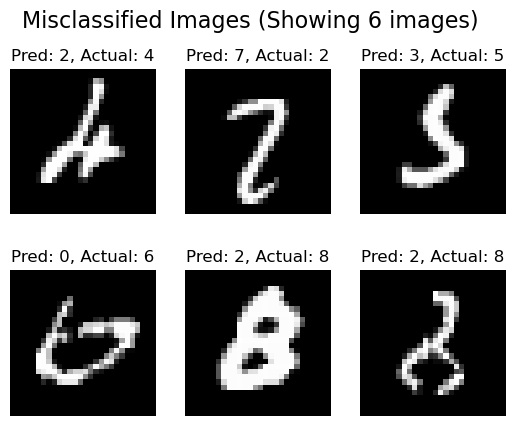

In [10]:
import math
num_rows = math.ceil(number_of_missclassified_to_show / 3)
num_cols = min(number_of_missclassified_to_show, 3)
plt.suptitle(f'Misclassified Images (Showing {number_of_missclassified_to_show} images)', fontsize=16)
for i, (img, pred, actual) in enumerate(misclassified_images[:number_of_missclassified_to_show]):
    img = img.reshape(28, 28).numpy()  # Adjust reshape if images are not 28x28
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Pred: {pred.item()}, Actual: {actual.item()}')
    plt.axis('off')
plt.show()

add a plot of the train and test error graphs during training

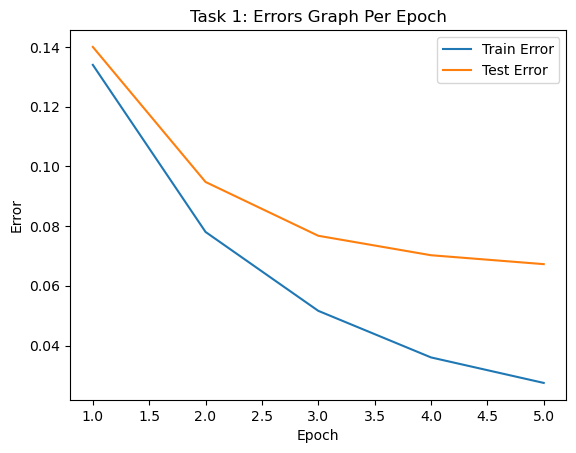

In [11]:
# Graphs for each epoch
import numpy as np
x_axis_test = np.arange(1, len(all_epochs_test_errors) + 1) # so x axis is from 1 to 5
x_axis_train = np.arange(1, len(all_epochs_train_errors) + 1) # so x axis is from 1 to 5

plt.plot(x_axis_train,all_epochs_train_errors, label=f'Train Error')
plt.plot(x_axis_test,all_epochs_test_errors, label=f'Test Error')

plt.ylabel("Error")
plt.xlabel("Epoch")
plt.title("Task 1: Errors Graph Per Epoch")
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()